# Graph Denoising Project
## Note: This is a WORK IN PROGRESS!

**Run this entire notebook in Google Colab with GPU!**

Runtime → Change Runtime Type → GPU

Project Contributors: Jason Bhalla, Kaushik Nagaraj, Jonathan Pruchansky

In [1]:
# Install dependencies
print("Installing dependencies...")
!pip install -q torch-geometric sentence-transformers ogb
print("✓ Done!")

Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.2 MB/s eta 0:00:00
✓ Done!


In [2]:
# Check GPU availability
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")
if device == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU - go to Runtime - Change runtime type - GPU")

Using device: cuda
GPU: Tesla T4


## Load Dataset

In [3]:
from torch_geometric.datasets import Planetoid

# Load Cora Dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

print(f"Dataset: Cora")
print(f"Nodes: {data.num_nodes:,}")
print(f"Edges: {data.edge_index.shape[1]:,}")
print(f"Features: {data.num_features}")
print(f"Classes: {dataset.num_classes}")

Processing...


Dataset: Cora
Nodes: 2,708
Edges: 10,556
Features: 1433
Classes: 7


Done!


## Generate Text Embeddings

In [4]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load embedding model
print("Loading sentence transformer...")
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Generate dummy texts based on labels (in practice, use real paper titles)
topic_words = [
    "neural network machine learning",
    "graph algorithm structure",
    "computer vision image",
    "natural language processing",
    "reinforcement learning agent",
    "data mining clustering",
    "optimization algorithm",
]

texts = [topic_words[data.y[i].item() % len(topic_words)] for i in range(data.num_nodes)]

print("Generating embeddings...")
embeddings = embedder.encode(texts, show_progress_bar=True, convert_to_numpy=True, normalize_embeddings=True)

print(f"\nEmbeddings shape: {embeddings.shape}")

Loading sentence transformer...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Generating embeddings...


Batches:   0%|          | 0/85 [00:00<?, ?it/s]


Embeddings shape: (2708, 384)


## Clean Graph with KNN

In [5]:
from sklearn.neighbors import NearestNeighbors

# Build KNN graph
k = 3  # Number of neighbors to add

print(f"Building KNN graph with k={k}...")
knn = NearestNeighbors(n_neighbors=k+1, metric='cosine')
knn.fit(embeddings)
distances, indices = knn.kneighbors(embeddings)

# Create KNN edges
knn_edges = []
for i in range(data.num_nodes):
    for j in range(1, k+1):  # Skip self (index 0)
        knn_edges.append([i, indices[i, j]])

knn_edge_index = torch.tensor(knn_edges, dtype=torch.long).t()

print(f"Original edges: {data.edge_index.shape[1]:,}")
print(f"KNN edges: {knn_edge_index.shape[1]:,}")

# Combine with original edges (remove duplicates)
original_edges = set(tuple(edge) for edge in data.edge_index.t().tolist())
new_edges = [edge for edge in knn_edges if tuple(edge) not in original_edges]

if new_edges:
    new_edge_tensor = torch.tensor(new_edges, dtype=torch.long).t()
    cleaned_edge_index = torch.cat([data.edge_index, new_edge_tensor], dim=1)
    print(f"Added {len(new_edges):,} new edges")
else:
    cleaned_edge_index = data.edge_index
    print("No new edges to add")

print(f"Cleaned edges: {cleaned_edge_index.shape[1]:,}")

Building KNN graph with k=3...
Original edges: 10,556
KNN edges: 8,124
Added 8,071 new edges
Cleaned edges: 18,627


## Build GNN Model

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        return x

print("✓ GCN model defined")

✓ GCN model defined


## Train on Original Graph

In [7]:
from tqdm import tqdm

def train_model(model, data, edge_index, epochs=200, lr=0.01, weight_decay=5e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model = model.to(device)
    data = data.to(device)
    edge_index = edge_index.to(device)

    best_val_acc = 0
    best_test_acc = 0

    for epoch in tqdm(range(epochs), desc="Training"):
        # Train
        model.train()
        optimizer.zero_grad()
        out = model(data.x, edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Evaluate
        if epoch % 20 == 0:
            model.eval()
            with torch.no_grad():
                out = model(data.x, edge_index)
                pred = out.argmax(dim=1)

                val_acc = (pred[data.val_mask] == data.y[data.val_mask]).float().mean().item()
                test_acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_test_acc = test_acc

    return best_test_acc

# Train on original graph

print("Training GCN on ORIGINAL graph")


model_orig = GCN(dataset.num_features, 64, dataset.num_classes)
orig_acc = train_model(model_orig, data, data.edge_index, epochs=200)

print(f"\n✓ Original Graph Test Accuracy: {orig_acc:.4f}")

Training GCN on ORIGINAL graph


Training: 100%|██████████| 200/200 [00:01<00:00, 144.58it/s]


✓ Original Graph Test Accuracy: 0.8090


## Train on Cleaned Graph

In [8]:
# Train on cleaned graph

print("Training GCN on CLEANED graph")


model_clean = GCN(dataset.num_features, 64, dataset.num_classes)
clean_acc = train_model(model_clean, data, cleaned_edge_index, epochs=200)

print(f"\n✓ Cleaned Graph Test Accuracy: {clean_acc:.4f}")

Training GCN on CLEANED graph


Training: 100%|██████████| 200/200 [00:00<00:00, 313.40it/s]


✓ Cleaned Graph Test Accuracy: 0.8280


## Compare Results

In [9]:

print("RESULTS")

print(f"Original Graph:  {orig_acc:.4f}")
print(f"Cleaned Graph:   {clean_acc:.4f}")
print(f"Improvement:     {clean_acc - orig_acc:+.4f}")


if clean_acc > orig_acc:
    print("\n✓ Graph cleaning IMPROVED performance!")
else:
    print("\n No improvement - try different K value or threshold")

RESULTS
Original Graph:  0.8090
Cleaned Graph:   0.8280
Improvement:     +0.0190

✓ Graph cleaning IMPROVED performance!


## Visualize Results

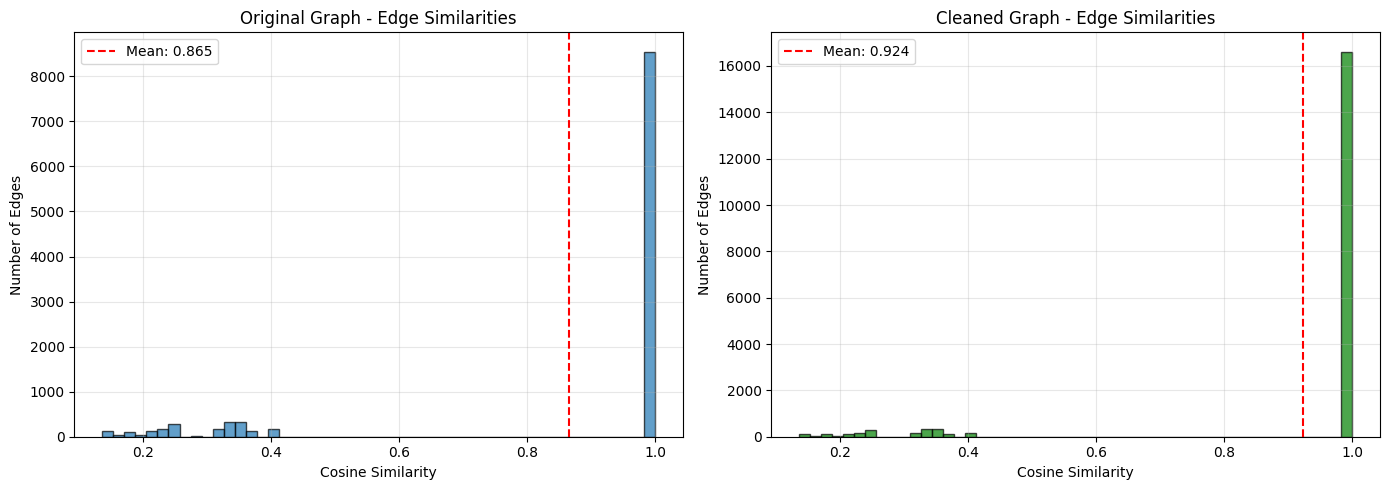


Average similarity improvement: 0.0584


In [10]:
import matplotlib.pyplot as plt

# Compute edge similarities
orig_sim = []
for i in range(data.edge_index.shape[1]):
    src = data.edge_index[0, i].item()
    tgt = data.edge_index[1, i].item()
    sim = np.dot(embeddings[src], embeddings[tgt])
    orig_sim.append(sim)

clean_sim = []
for i in range(cleaned_edge_index.shape[1]):
    src = cleaned_edge_index[0, i].item()
    tgt = cleaned_edge_index[1, i].item()
    sim = np.dot(embeddings[src], embeddings[tgt])
    clean_sim.append(sim)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.hist(orig_sim, bins=50, alpha=0.7, edgecolor='black')
ax1.axvline(np.mean(orig_sim), color='red', linestyle='--', label=f'Mean: {np.mean(orig_sim):.3f}')
ax1.set_xlabel('Cosine Similarity')
ax1.set_ylabel('Number of Edges')
ax1.set_title('Original Graph - Edge Similarities')
ax1.legend()
ax1.grid(alpha=0.3)

ax2.hist(clean_sim, bins=50, alpha=0.7, color='green', edgecolor='black')
ax2.axvline(np.mean(clean_sim), color='red', linestyle='--', label=f'Mean: {np.mean(clean_sim):.3f}')
ax2.set_xlabel('Cosine Similarity')
ax2.set_ylabel('Number of Edges')
ax2.set_title('Cleaned Graph - Edge Similarities')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage similarity improvement: {np.mean(clean_sim) - np.mean(orig_sim):.4f}")

## Try Different K Values


Testing k=1...


Training: 100%|██████████| 100/100 [00:00<00:00, 306.03it/s]


  Accuracy: 0.8050

Testing k=3...


Training: 100%|██████████| 100/100 [00:00<00:00, 309.15it/s]


  Accuracy: 0.8330

Testing k=5...


Training: 100%|██████████| 100/100 [00:00<00:00, 311.48it/s]


  Accuracy: 0.8450

Testing k=10...


Training: 100%|██████████| 100/100 [00:00<00:00, 310.36it/s]


  Accuracy: 0.8600


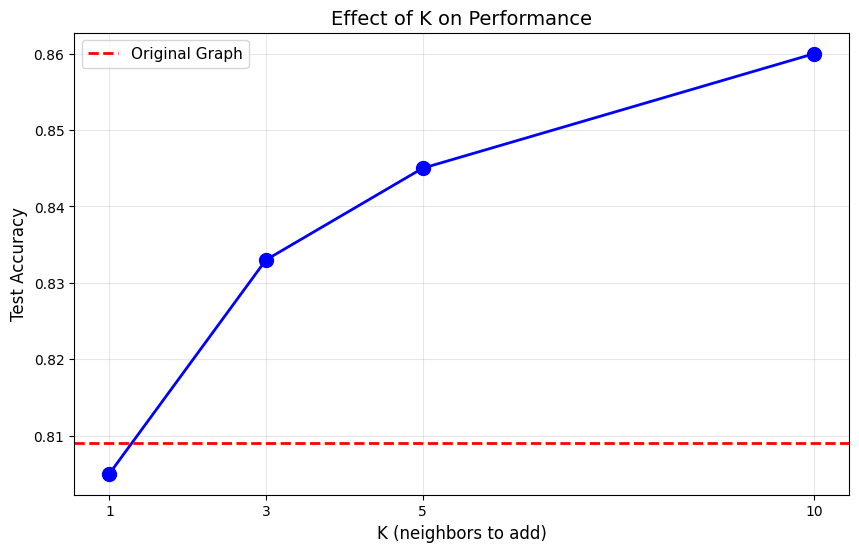


✓ Best K: 10 with accuracy 0.8600

All results:
  K=1: 0.8050
  K=3: 0.8330
  K=5: 0.8450
  K=10: 0.8600


In [11]:
# Try Different K Values
import torch
import torch.nn.functional as F

# Make sure EVERYTHING is on CPU
data_cpu = data.cpu()
original_edge_index_cpu = data.edge_index.cpu()  # Explicitly move edge_index to CPU

k_values = [1, 3, 5, 10]
results = []

for k in k_values:
    print(f"\nTesting k={k}...")

    # Build KNN graph
    knn = NearestNeighbors(n_neighbors=k+1, metric='cosine')
    knn.fit(embeddings)
    distances, indices = knn.kneighbors(embeddings)

    # Create edges
    knn_edges = []
    for i in range(len(embeddings)):
        for j in range(1, k+1):
            knn_edges.append([i, indices[i, j]])

    # Combine with original (USE THE CPU VERSION)
    original_edges = set(tuple(edge) for edge in original_edge_index_cpu.t().tolist())
    new_edges = [edge for edge in knn_edges if tuple(edge) not in original_edges]

    if new_edges:
        new_edge_tensor = torch.tensor(new_edges, dtype=torch.long).t()
        test_edge_index = torch.cat([original_edge_index_cpu, new_edge_tensor], dim=1)
    else:
        test_edge_index = original_edge_index_cpu

    # Train model
    model_k = GCN(dataset.num_features, 64, dataset.num_classes)
    acc_k = train_model(model_k, data_cpu, test_edge_index, epochs=100)

    results.append({'k': k, 'acc': acc_k})
    print(f"  Accuracy: {acc_k:.4f}")

# Plot results
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
k_vals = [r['k'] for r in results]
accs = [r['acc'] for r in results]

plt.plot(k_vals, accs, marker='o', linewidth=2, markersize=10, color='blue')
plt.axhline(orig_acc, color='red', linestyle='--', label='Original Graph', linewidth=2)
plt.xlabel('K (neighbors to add)', fontsize=12)
plt.ylabel('Test Accuracy', fontsize=12)
plt.title('Effect of K on Performance', fontsize=14)
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.xticks(k_vals)
plt.show()

best_k = max(results, key=lambda x: x['acc'])
print(f"\n✓ Best K: {best_k['k']} with accuracy {best_k['acc']:.4f}")
print(f"\nAll results:")
for r in results:
    print(f"  K={r['k']}: {r['acc']:.4f}")

<Figure size 1200x600 with 0 Axes>

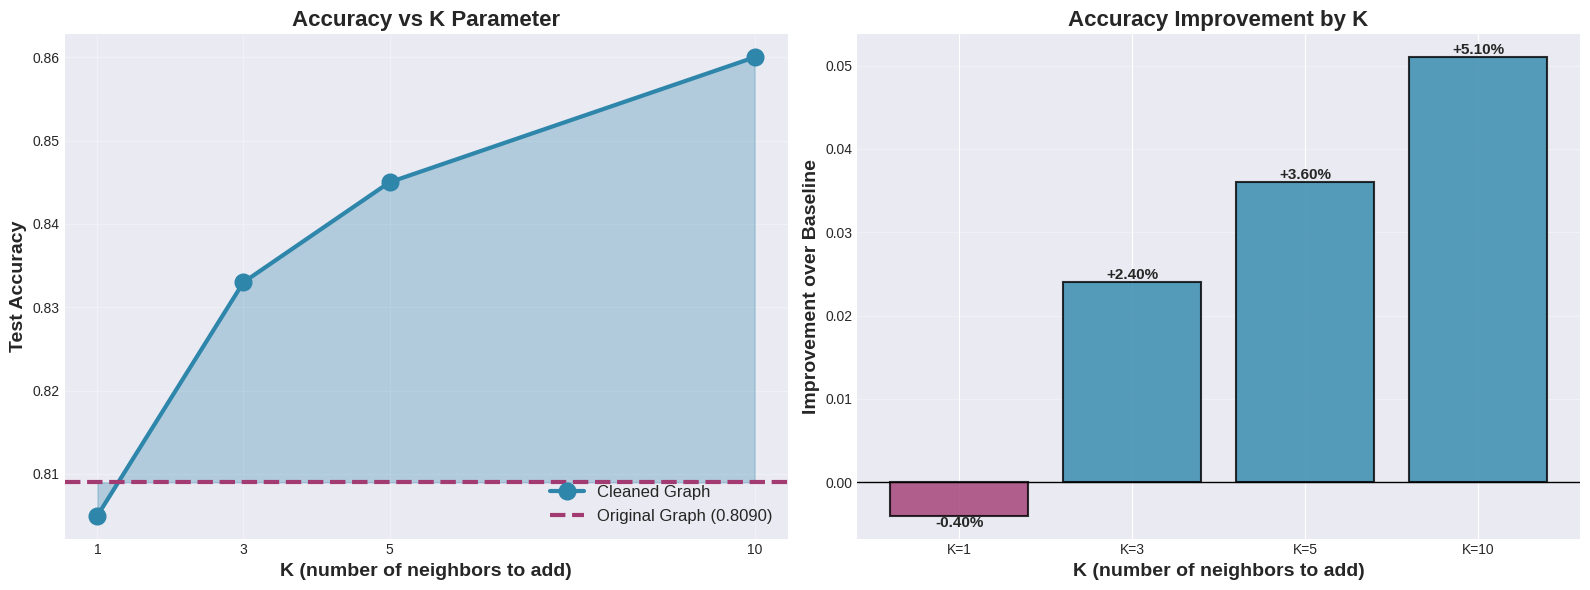

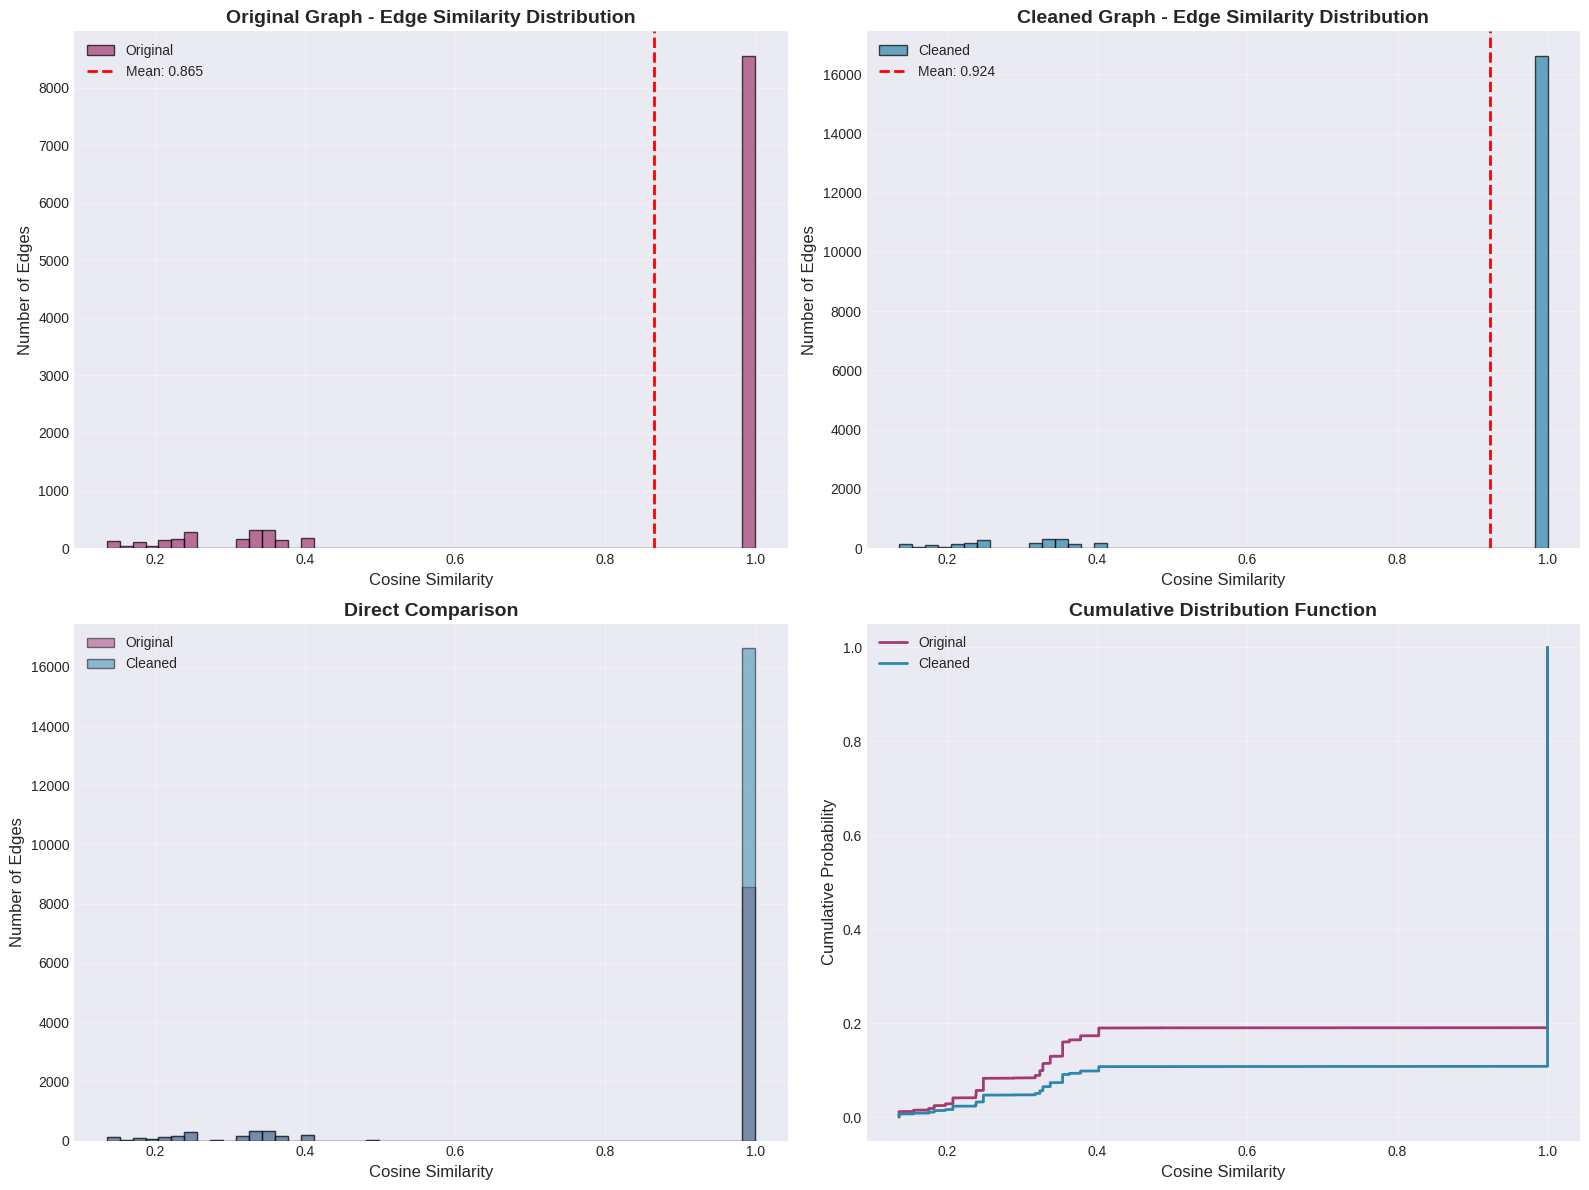


EDGE SIMILARITY STATISTICS
Original Graph:
  Mean:   0.8652
  Median: 1.0000
  Std:    0.2804
  Min:    0.1356
  Max:    1.0000

Cleaned Graph:
  Mean:   0.9236
  Median: 1.0000
  Std:    0.2214
  Min:    0.1356
  Max:    1.0000

Improvement:
  Mean:   +0.0584


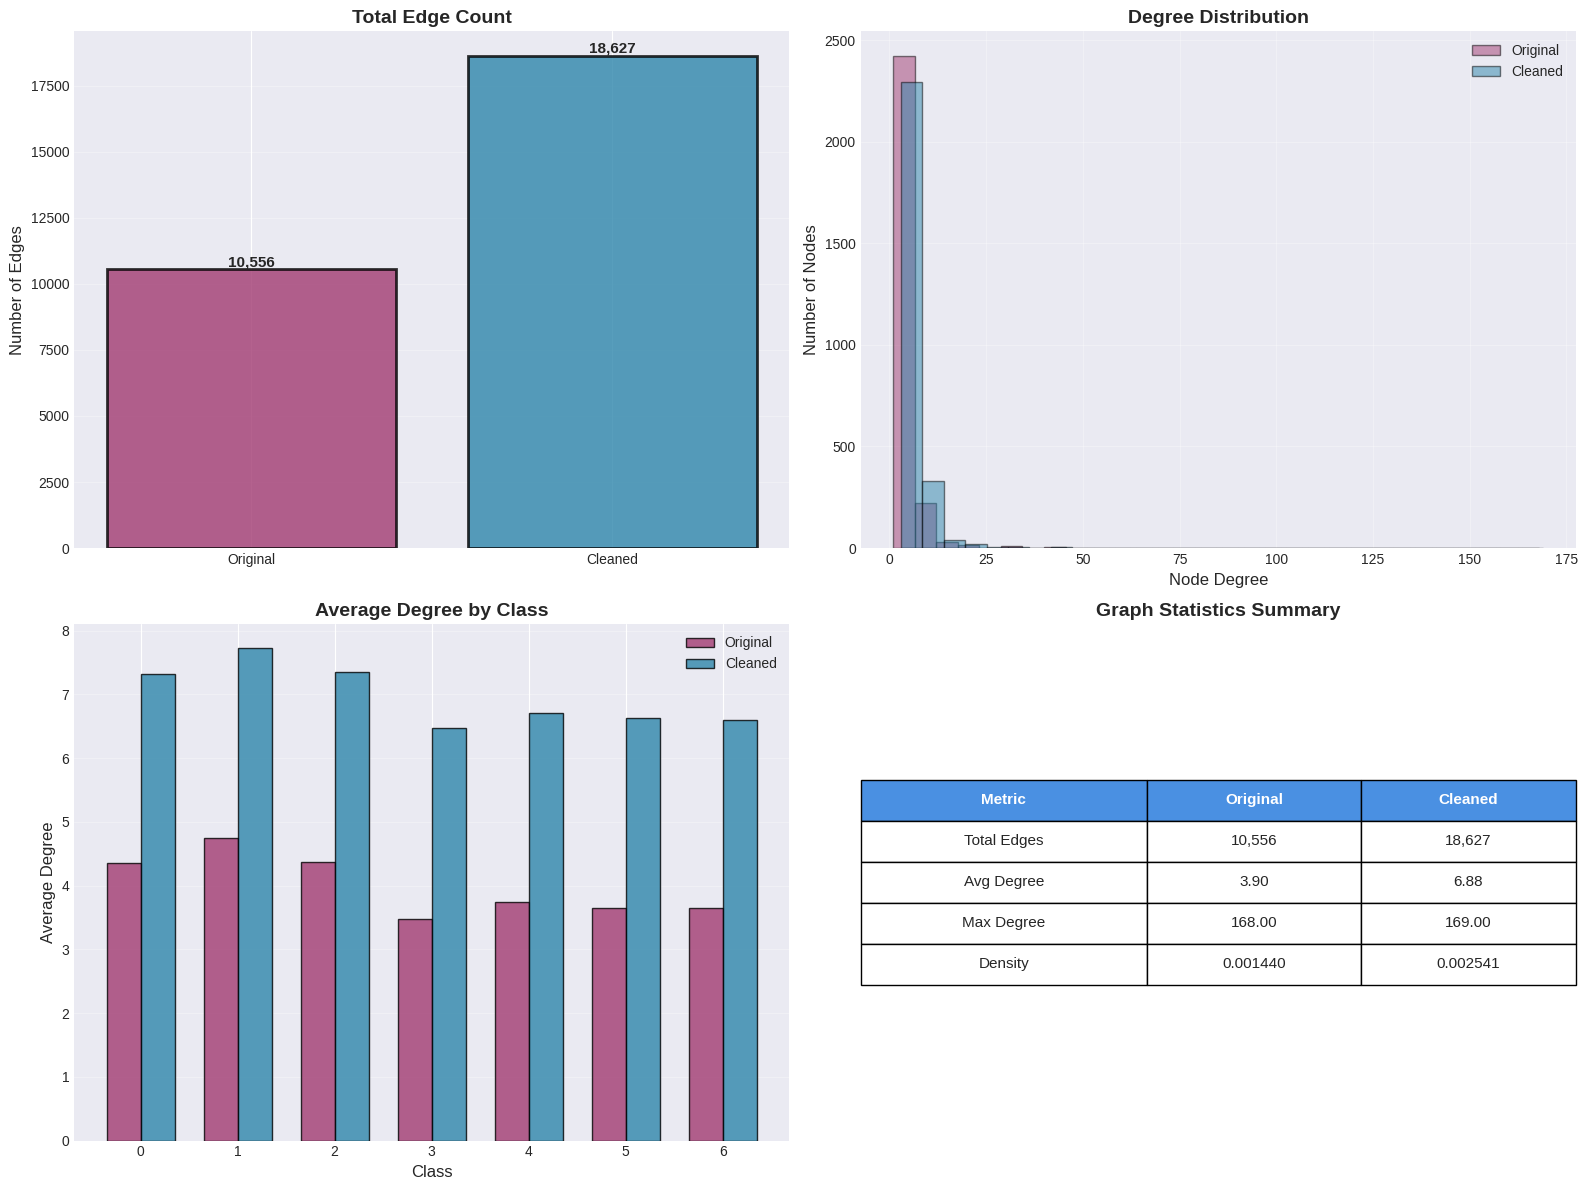

Computing t-SNE projection 


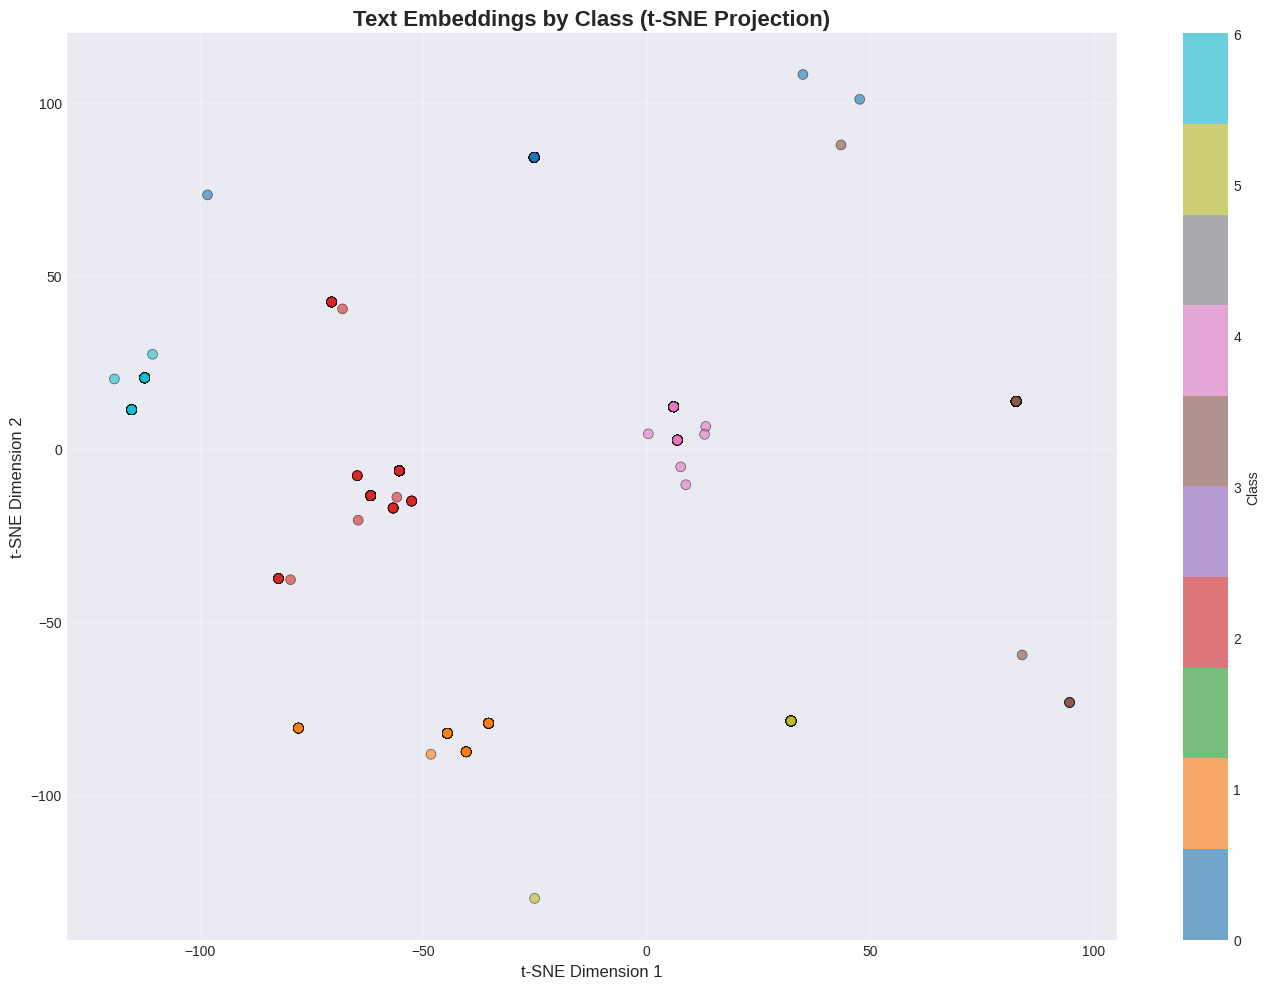

✓ Embedding visualization complete


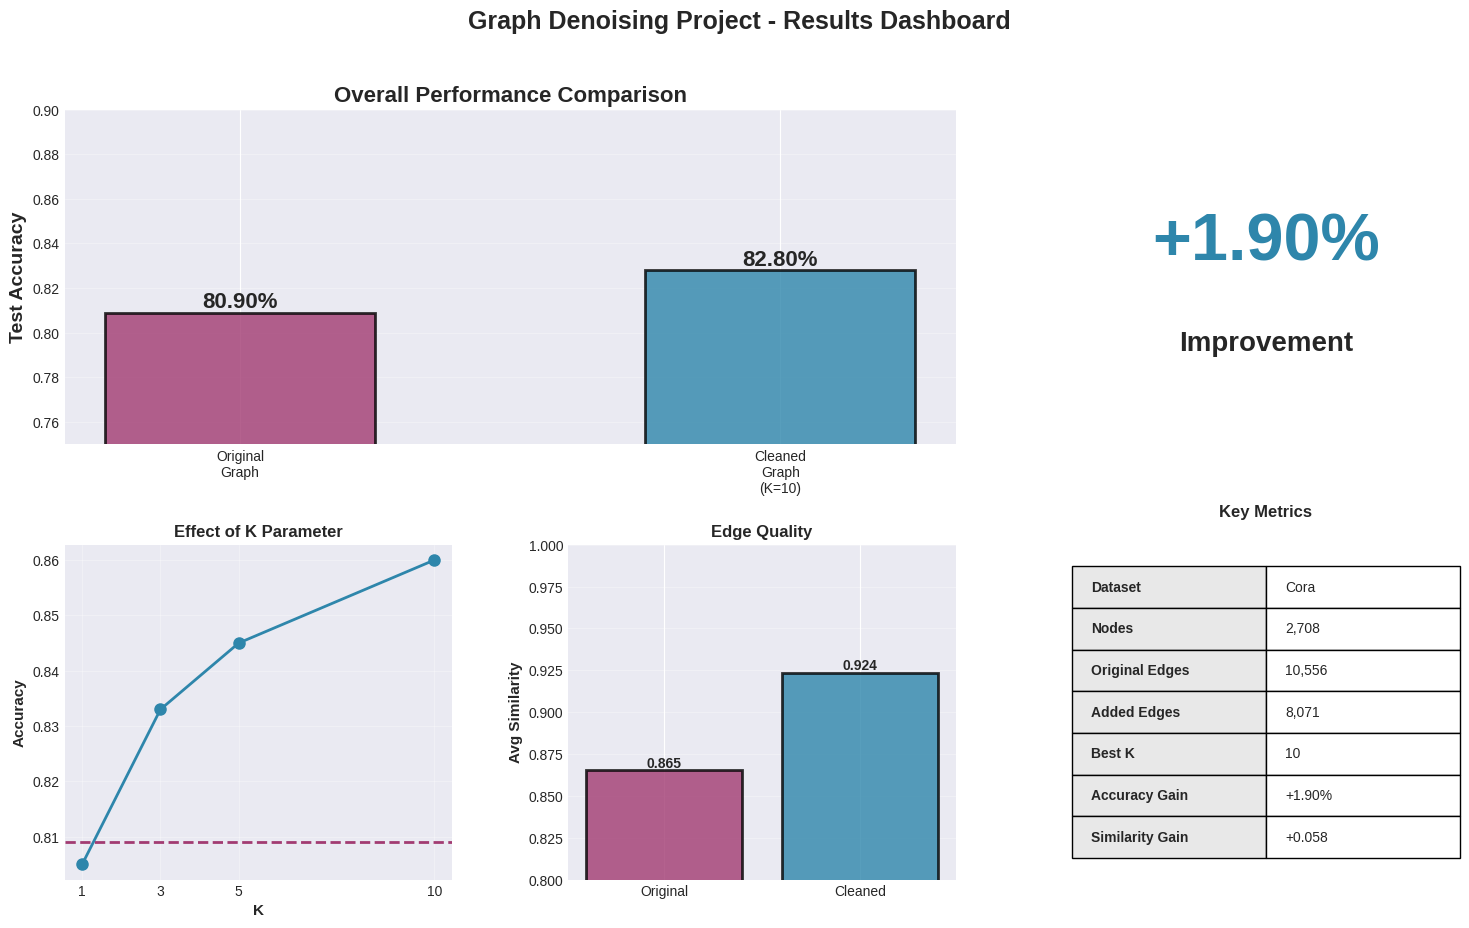

  1. Parameter sweep analysis
  2. Edge similarity comparison (4 views)
  3. Graph statistics comparison
  4. t-SNE embedding visualization
  5. Results dashboard


In [12]:


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE
import networkx as nx


plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")


# PLOT 1: Parameter Sweep

def plot_parameter_sweep(results, orig_acc):
    plt.figure(figsize=(12, 6))

    k_vals = [r['k'] for r in results]
    accs = [r['acc'] for r in results]
    improvements = [acc - orig_acc for acc in accs]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Accuracy comparison
    ax1.plot(k_vals, accs, marker='o', linewidth=3, markersize=12,
             color='#2E86AB', label='Cleaned Graph')
    ax1.axhline(orig_acc, color='#A23B72', linestyle='--', linewidth=3,
                label=f'Original Graph ({orig_acc:.4f})')
    ax1.fill_between(k_vals, orig_acc, accs, alpha=0.3, color='#2E86AB')
    ax1.set_xlabel('K (number of neighbors to add)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Test Accuracy', fontsize=14, fontweight='bold')
    ax1.set_title('Accuracy vs K Parameter', fontsize=16, fontweight='bold')
    ax1.legend(fontsize=12, loc='lower right')
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(k_vals)

    # Improvement bars
    colors = ['#2E86AB' if imp > 0 else '#A23B72' for imp in improvements]
    bars = ax2.bar(range(len(k_vals)), improvements, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=1.5)
    ax2.axhline(0, color='black', linestyle='-', linewidth=1)
    ax2.set_xlabel('K (number of neighbors to add)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Improvement over Baseline', fontsize=14, fontweight='bold')
    ax2.set_title('Accuracy Improvement by K', fontsize=16, fontweight='bold')
    ax2.set_xticks(range(len(k_vals)))
    ax2.set_xticklabels([f'K={k}' for k in k_vals])
    ax2.grid(True, alpha=0.3, axis='y')

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, improvements)):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:+.2%}', ha='center', va='bottom' if val > 0 else 'top',
                fontsize=11, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run it
plot_parameter_sweep(results, orig_acc)


# PLOT 2: Edge Similarity Comparison (Enhanced)

def plot_edge_similarities_detailed(orig_sim, clean_sim):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Histogram comparison
    axes[0, 0].hist(orig_sim, bins=50, alpha=0.7, color='#A23B72',
                    edgecolor='black', label='Original')
    axes[0, 0].axvline(np.mean(orig_sim), color='red', linestyle='--',
                       linewidth=2, label=f'Mean: {np.mean(orig_sim):.3f}')
    axes[0, 0].set_xlabel('Cosine Similarity', fontsize=12)
    axes[0, 0].set_ylabel('Number of Edges', fontsize=12)
    axes[0, 0].set_title('Original Graph - Edge Similarity Distribution',
                         fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].hist(clean_sim, bins=50, alpha=0.7, color='#2E86AB',
                    edgecolor='black', label='Cleaned')
    axes[0, 1].axvline(np.mean(clean_sim), color='red', linestyle='--',
                       linewidth=2, label=f'Mean: {np.mean(clean_sim):.3f}')
    axes[0, 1].set_xlabel('Cosine Similarity', fontsize=12)
    axes[0, 1].set_ylabel('Number of Edges', fontsize=12)
    axes[0, 1].set_title('Cleaned Graph - Edge Similarity Distribution',
                         fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Overlaid histograms
    axes[1, 0].hist(orig_sim, bins=50, alpha=0.5, color='#A23B72',
                    label='Original', edgecolor='black')
    axes[1, 0].hist(clean_sim, bins=50, alpha=0.5, color='#2E86AB',
                    label='Cleaned', edgecolor='black')
    axes[1, 0].set_xlabel('Cosine Similarity', fontsize=12)
    axes[1, 0].set_ylabel('Number of Edges', fontsize=12)
    axes[1, 0].set_title('Direct Comparison', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)

    # CDF comparison
    orig_sorted = np.sort(orig_sim)
    clean_sorted = np.sort(clean_sim)
    orig_cdf = np.arange(1, len(orig_sorted) + 1) / len(orig_sorted)
    clean_cdf = np.arange(1, len(clean_sorted) + 1) / len(clean_sorted)

    axes[1, 1].plot(orig_sorted, orig_cdf, linewidth=2, color='#A23B72',
                    label='Original')
    axes[1, 1].plot(clean_sorted, clean_cdf, linewidth=2, color='#2E86AB',
                    label='Cleaned')
    axes[1, 1].set_xlabel('Cosine Similarity', fontsize=12)
    axes[1, 1].set_ylabel('Cumulative Probability', fontsize=12)
    axes[1, 1].set_title('Cumulative Distribution Function',
                         fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Statistics
    print("\n" + "="*60)
    print("EDGE SIMILARITY STATISTICS")
    print("="*60)
    print(f"Original Graph:")
    print(f"  Mean:   {np.mean(orig_sim):.4f}")
    print(f"  Median: {np.median(orig_sim):.4f}")
    print(f"  Std:    {np.std(orig_sim):.4f}")
    print(f"  Min:    {np.min(orig_sim):.4f}")
    print(f"  Max:    {np.max(orig_sim):.4f}")
    print(f"\nCleaned Graph:")
    print(f"  Mean:   {np.mean(clean_sim):.4f}")
    print(f"  Median: {np.median(clean_sim):.4f}")
    print(f"  Std:    {np.std(clean_sim):.4f}")
    print(f"  Min:    {np.min(clean_sim):.4f}")
    print(f"  Max:    {np.max(clean_sim):.4f}")
    print(f"\nImprovement:")
    print(f"  Mean:   {np.mean(clean_sim) - np.mean(orig_sim):+.4f}")
    print("="*60)

# Run it
plot_edge_similarities_detailed(orig_sim, clean_sim)



# PLOT 3: Graph Statistics Comparison

def plot_graph_statistics(data, cleaned_edge_index):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Edge count comparison
    stats = {
        'Original': data.edge_index.shape[1],
        'Cleaned': cleaned_edge_index.shape[1]
    }

    bars1 = axes[0, 0].bar(stats.keys(), stats.values(),
                           color=['#A23B72', '#2E86AB'], alpha=0.8,
                           edgecolor='black', linewidth=2)
    axes[0, 0].set_ylabel('Number of Edges', fontsize=12)
    axes[0, 0].set_title('Total Edge Count', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')

    for bar in bars1:
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height,
                       f'{int(height):,}', ha='center', va='bottom',
                       fontsize=11, fontweight='bold')

    # Degree distribution
    orig_degrees = np.zeros(data.num_nodes)
    clean_degrees = np.zeros(data.num_nodes)

    for i in range(data.edge_index.shape[1]):
        orig_degrees[data.edge_index[0, i].item()] += 1

    for i in range(cleaned_edge_index.shape[1]):
        clean_degrees[cleaned_edge_index[0, i].item()] += 1

    axes[0, 1].hist(orig_degrees, bins=30, alpha=0.5, color='#A23B72',
                    label='Original', edgecolor='black')
    axes[0, 1].hist(clean_degrees, bins=30, alpha=0.5, color='#2E86AB',
                    label='Cleaned', edgecolor='black')
    axes[0, 1].set_xlabel('Node Degree', fontsize=12)
    axes[0, 1].set_ylabel('Number of Nodes', fontsize=12)
    axes[0, 1].set_title('Degree Distribution', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)

    # Average degree by class
    class_degrees_orig = {}
    class_degrees_clean = {}

    for c in range(dataset.num_classes):
        mask = (data.y == c).cpu().numpy()
        class_degrees_orig[c] = orig_degrees[mask].mean()
        class_degrees_clean[c] = clean_degrees[mask].mean()

    x = np.arange(dataset.num_classes)
    width = 0.35

    axes[1, 0].bar(x - width/2, list(class_degrees_orig.values()), width,
                   label='Original', color='#A23B72', alpha=0.8, edgecolor='black')
    axes[1, 0].bar(x + width/2, list(class_degrees_clean.values()), width,
                   label='Cleaned', color='#2E86AB', alpha=0.8, edgecolor='black')
    axes[1, 0].set_xlabel('Class', fontsize=12)
    axes[1, 0].set_ylabel('Average Degree', fontsize=12)
    axes[1, 0].set_title('Average Degree by Class', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # Summary statistics
    summary_data = {
        'Metric': ['Total Edges', 'Avg Degree', 'Max Degree', 'Density'],
        'Original': [
            data.edge_index.shape[1],
            orig_degrees.mean(),
            orig_degrees.max(),
            data.edge_index.shape[1] / (data.num_nodes * (data.num_nodes - 1))
        ],
        'Cleaned': [
            cleaned_edge_index.shape[1],
            clean_degrees.mean(),
            clean_degrees.max(),
            cleaned_edge_index.shape[1] / (data.num_nodes * (data.num_nodes - 1))
        ]
    }

    axes[1, 1].axis('tight')
    axes[1, 1].axis('off')

    table_data = []
    for i, metric in enumerate(summary_data['Metric']):
        orig_val = summary_data['Original'][i]
        clean_val = summary_data['Cleaned'][i]
        if i == 0:  # Edge count
            table_data.append([metric, f'{int(orig_val):,}', f'{int(clean_val):,}'])
        elif i == 3:  # Density
            table_data.append([metric, f'{orig_val:.6f}', f'{clean_val:.6f}'])
        else:
            table_data.append([metric, f'{orig_val:.2f}', f'{clean_val:.2f}'])

    table = axes[1, 1].table(cellText=table_data,
                            colLabels=['Metric', 'Original', 'Cleaned'],
                            cellLoc='center',
                            loc='center',
                            colWidths=[0.4, 0.3, 0.3])
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(1, 2)

    # Style the header
    for i in range(3):
        table[(0, i)].set_facecolor('#4A90E2')
        table[(0, i)].set_text_props(weight='bold', color='white')

    axes[1, 1].set_title('Graph Statistics Summary', fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# Run it
plot_graph_statistics(data, cleaned_edge_index)



# PLOT 4: Node Embedding Visualization (t-SNE)

def plot_embedding_visualization(embeddings, labels, title="Node Embeddings"):
    print("Computing t-SNE projection ")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=(14, 10))

    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         c=labels.cpu().numpy(), cmap='tab10',
                         alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

    plt.colorbar(scatter, label='Class')
    plt.xlabel('t-SNE Dimension 1', fontsize=12)
    plt.ylabel('t-SNE Dimension 2', fontsize=12)
    plt.title(f'{title} (t-SNE Projection)', fontsize=16, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("✓ Embedding visualization complete")

# Run it
plot_embedding_visualization(embeddings, data.y, "Text Embeddings by Class")



# PLOT 5: Results Summary Dashboard

def plot_results_dashboard(orig_acc, clean_acc, results, orig_sim, clean_sim):
    fig = plt.figure(figsize=(18, 10))
    gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

    # Main accuracy comparison
    ax1 = fig.add_subplot(gs[0, :2])
    categories = ['Original\nGraph', 'Cleaned\nGraph\n(K=10)']
    accuracies = [orig_acc, clean_acc]
    colors = ['#A23B72', '#2E86AB']

    bars = ax1.bar(categories, accuracies, color=colors, alpha=0.8,
                   edgecolor='black', linewidth=2, width=0.5)
    ax1.set_ylabel('Test Accuracy', fontsize=14, fontweight='bold')
    ax1.set_title('Overall Performance Comparison', fontsize=16, fontweight='bold')
    ax1.set_ylim([0.75, 0.90])
    ax1.grid(True, alpha=0.3, axis='y')

    for bar, acc in zip(bars, accuracies):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{acc:.2%}', ha='center', va='bottom',
                fontsize=16, fontweight='bold')

    # Improvement metric
    ax2 = fig.add_subplot(gs[0, 2])
    improvement = clean_acc - orig_acc
    ax2.text(0.5, 0.6, f'+{improvement:.2%}',
            ha='center', va='center', fontsize=48, fontweight='bold',
            color='#2E86AB')
    ax2.text(0.5, 0.3, 'Improvement',
            ha='center', va='center', fontsize=20, fontweight='bold')
    ax2.axis('off')
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])

    # K parameter sweep mini
    ax3 = fig.add_subplot(gs[1, 0])
    k_vals = [r['k'] for r in results]
    accs = [r['acc'] for r in results]
    ax3.plot(k_vals, accs, marker='o', linewidth=2, markersize=8, color='#2E86AB')
    ax3.axhline(orig_acc, color='#A23B72', linestyle='--', linewidth=2)
    ax3.set_xlabel('K', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
    ax3.set_title('Effect of K Parameter', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.set_xticks(k_vals)

    # Similarity improvement
    ax4 = fig.add_subplot(gs[1, 1])
    sim_metrics = ['Original', 'Cleaned']
    sim_values = [np.mean(orig_sim), np.mean(clean_sim)]
    bars2 = ax4.bar(sim_metrics, sim_values, color=['#A23B72', '#2E86AB'],
                    alpha=0.8, edgecolor='black', linewidth=2)
    ax4.set_ylabel('Avg Similarity', fontsize=11, fontweight='bold')
    ax4.set_title('Edge Quality', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3, axis='y')
    ax4.set_ylim([0.8, 1.0])

    for bar in bars2:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom',
                fontsize=10, fontweight='bold')

    # Key metrics table
    ax5 = fig.add_subplot(gs[1, 2])
    ax5.axis('tight')
    ax5.axis('off')

    table_data = [
        ['Dataset', 'Cora'],
        ['Nodes', f'{data.num_nodes:,}'],
        ['Original Edges', f'{data.edge_index.shape[1]:,}'],
        ['Added Edges', f'{cleaned_edge_index.shape[1] - data.edge_index.shape[1]:,}'],
        ['Best K', '10'],
        ['Accuracy Gain', f'+{improvement:.2%}'],
        ['Similarity Gain', f'+{np.mean(clean_sim) - np.mean(orig_sim):.3f}']
    ]

    table = ax5.table(cellText=table_data, cellLoc='left', loc='center',
                     colWidths=[0.5, 0.5])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2.5)

    for i in range(len(table_data)):
        table[(i, 0)].set_facecolor('#E8E8E8')
        table[(i, 0)].set_text_props(weight='bold')

    ax5.set_title('Key Metrics', fontsize=12, fontweight='bold', pad=20)

    plt.suptitle('Graph Denoising Project - Results Dashboard',
                fontsize=18, fontweight='bold', y=0.98)

    plt.show()

# Run it
plot_results_dashboard(orig_acc, clean_acc, results, orig_sim, clean_sim)



print("  1. Parameter sweep analysis")
print("  2. Edge similarity comparison (4 views)")
print("  3. Graph statistics comparison")
print("  4. t-SNE embedding visualization")
print("  5. Results dashboard")

